# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('data/human_body_temperature.csv')

### First look at the dataset

In [2]:
# Your work here.
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


In [3]:
df.groupby('gender').describe()

heart_rate                                                     \
            count       mean       std   min   25%   50%   75%   max   
gender                                                                 
F            65.0  74.153846  8.105227  57.0  68.0  76.0  80.0  89.0   
M            65.0  73.369231  5.875184  58.0  70.0  73.0  78.0  86.0   

       temperature                                                      
             count       mean       std   min   25%   50%   75%    max  
gender                                                                  
F             65.0  98.393846  0.743488  96.4  98.0  98.4  98.8  100.8  
M             65.0  98.104615  0.698756  96.3  97.6  98.1  98.6   99.5

In [4]:
df['temperature'].mean()

98.24923076923078

* The dataset contains 130 samples of temperatures and heart rates equally distributed between males and females. 
* The formerely presumed average temperature of 98.6F is higher than the sample mean of 98.25F, and also higher than the means for both males and females. How significant are these differences?

### 1. Is the distribution of body temperatures normal?

Body temperature is a function of a large number of physiological parameters and processes that vary slightly from person to person, which could lead to normally distributed values.

** 1.1 Graphical methods **

 The first semiquantitative inspection for larger deviations from normality can be done using graphical methods.
We can start by visually comparing the histogram of the sample data with a normal distribribution having the sample mean and variance:

In [5]:
# sample count, sample mean, variance, and standard deviation of body temperature
n = df.temperature.count()
mu = df.temperature.mean()
sig2 = df.temperature.var()*n/(n-1)
sig = df.temperature.std()*np.sqrt(n/(n-1))
mu, sig2, n

(98.24923076923078, 0.54172465597019348, 130)

In [6]:
# Define normal distribution with a given mean mu, and variance sig2
def normal_dist(x, mu, sig2):
    return np.exp(-(x-mu)**2/(2.0*sig2))/np.sqrt(2.0*np.pi*sig2)

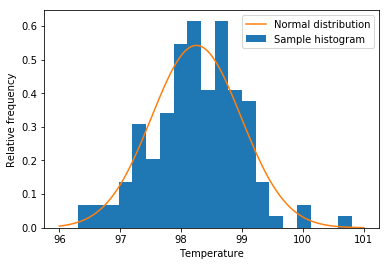

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(df.temperature, bins=20, normed=True, label='Sample histogram')
x = np.linspace(96,101,201)
plt.plot(x, normal_dist(x, mu, sig2), label='Normal distribution')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Relative frequency')

* The histogram looks skewed, with a few values between 100 and 101 F that seem out of place. Maybe sick people?

A more rigorous graphical tests include P-P (probability-probability) plot, which plots empirical vs. theoretical cummulative distribution functions, and Q-Q (quantile-quantile) plot, which plots empirical vs. theoretical quantile functions. Ideally, samples from a normal distribution should lie on a straight line with the slope of 45 degrees.

In [8]:
# Define Empirical cumulative distribution function needed for P-P plot
def ecdf(values):
    x = np.sort(values)
    y = np.linspace(0,1,x.shape[0])
    return x, y

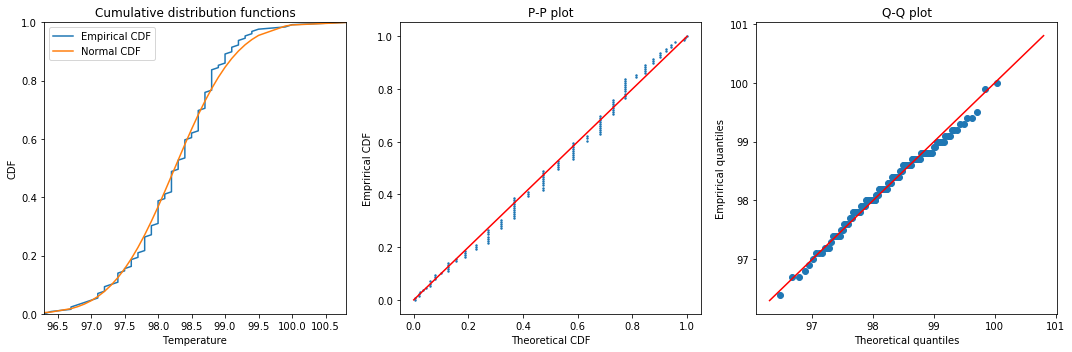

In [9]:
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.title('Cumulative distribution functions')
# Empirical CDF
x, y = ecdf(df.temperature)
plt.plot(x, y, label='Empirical CDF')
# Normal CDF (=error function)
from scipy.special import erf
y_normal = 0.5*(1.0 + erf((x - mu)/np.sqrt(2.0*sig2)))
plt.plot(x, y_normal, label='Normal CDF')
#plt.plot(x_normal, y_normal, label='Normal CDF')
plt.xlabel('Temperature')
plt.ylabel('CDF')
plt.legend()
plt.xlim(x.min(), x.max())
plt.ylim(0.0, 1.0)

plt.subplot(132)
plt.title('P-P plot')
plt.scatter(y_normal, y, s=2)
plt.plot([0,1], [0,1], c='r')
plt.xlabel('Theoretical CDF')
plt.ylabel('Emprirical CDF')

plt.subplot(133)
plt.title('Q-Q plot')
# - normal quantile function for quantiles defined by the empirical CDF
from scipy.stats import norm
# x - empirical quantile function
# norm.ppf(y) - normal quantile function for percentile values defined by empirical percentiles
#plt.scatter(y, x)
plt.scatter(norm.ppf(y, loc=mu, scale=np.sqrt(sig2)), x)
plt.plot(x, x, c='r')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Emprirical quantiles')
#plt.xlim(x.min(), x.max())
plt.tight_layout()

In [10]:
from scipy.stats import pearsonr
pearsonr(norm.ppf(y, loc=mu, scale=np.sqrt(sig2))[1:-2], x[1:-2])

(0.99485516607293867, 3.630712026632685e-126)

* The graphical methods indicate that the sample closely resembles a sample from the normal distribution. Pearson coefficient based on the Q-Q plot is ~0.995, confirming nearly linear correlation between the empirical and theoretical quantile functions.

** 1.2 Quantitative normality tests - frequentist methods **

There are a number of frequentist hypothesis tests with the null hypothesis being that the samples were obtained from a normal distribution. Based on published comparisons, Shapiro-Wilk test has been found to have the highest statistical power (correctly rejects false null hypothesis - minimizes Type II error). We also try two other tests: Anderson-Darling, and Kolmogorov-Smirnov.

In [11]:
from scipy.stats import shapiro, anderson, kstest
print("Shapiro-Wilk statistic:", shapiro(df.temperature)[0])
print("Shapiro-Wilk p-value:", shapiro(df.temperature)[1])

Shapiro-Wilk statistic: 0.9865770936012268
Shapiro-Wilk p-value: 0.233174666762352


** Result:** Based on the p-value of ~0.23 and the typical significance level alpha = 0.05, we cannot reject the null hypothesis that the sample comes from the normal distribution.

In [12]:
print("Anderson-Darling statistic:", anderson(df.temperature)[0])
print("Anderson-Darling critical values:", anderson(df.temperature)[1])
print("Anderson-Darling significance level:", anderson(df.temperature)[2])

Anderson-Darling statistic: 0.520103882671
Anderson-Darling critical values: [ 0.56   0.637  0.765  0.892  1.061]
Anderson-Darling significance level: [ 15.   10.    5.    2.5   1. ]


** Result: ** The A-D statistic is smaller than all shown critical values. Even at 15% (0.15) significance level, we could not reject the null hypothesis (normality).

In [13]:
print("Kolmogorov-Smirnov statistic:", kstest(df.temperature, 'norm', args=(mu, np.sqrt(sig2)))[0])
print("Kolmogorov-Smirnov p-value:", kstest(df.temperature, 'norm', args=(mu, np.sqrt(sig2)))[1])

Kolmogorov-Smirnov statistic: 0.0655987486494
Kolmogorov-Smirnov p-value: 0.625884398447


** Result: ** The p-value for the K-S test also strongly suggests that we should not reject the null hypothesis. The p-value is larger than for the S-W test -> K-S seems more permissive.

### 2. Is the sample size large? Are the observations independent?

The answer depends on the task we want to accomplish and the properties of the population distribution. In the present case, our distribution is symmetric, unimodal, and without significant outliers. Based on the previous analysis, the population distribution also satisfies various measures of normality.

As a rule of thumb for normally distributed populations, sample size of n $\ge 30$ is generally considered sufficiently large.

For a given task of estimating population mean (e.g., average temperature) with a given confidence, we can proceed more quantiatively. The standard error of the estimate is given as $\frac{\sigma}{\sqrt{n}}$. In our case we take the sample number n = 130.

If we assume that the population std is equal to sample std, we can use normal distribution to determine 95% confidence interval as being within approximately $1.96\sigma$ from the mean.

In [14]:
1.96*(sig2/n)**0.5

0.12652422809562219

* With 95% confidence, the sample mean will lie within $\pm0.126$ F from the population mean.

However, since we do not know the true population mean, a more accurate confidence interval estimate should be based on the t-distribution rather than the normal distribution. For the given sample size of n=130, the t-distribution is close to the normal distribution, with the 95% confidence interval values lying within $\pm 2s$ where $s$ is the sample standard deviation.


In [15]:
2.0*(sig2/n)**0.5

0.1291063551996145

* More accurately, with 95% confidence, the sample mean will lie within $\pm0.13$ F from the population mean.

** Summary ** If we want our population mean estimate lie within 0.13 F from the true mean with 95% confidence, than our sample size is large enough. Higer precision or confidence will require larger samples. Given that the difference between the sample mean of 98.25 F and the historical value of 98.6 F is larger than 0.13 F, the sample size should be large enough for testing related hypotheses.

** Are the observations independent? **
* According to the linked source "Data were constructed to match as closely as possible the histograms and summary statistics presented in that article."
* While the sample selection process was not completely random and independent (as certain combinations of samples were preferred), we can assume that the process was controlled not to introduce bias and spurious correlations, and the observations in the dataset can be considered independent for our purposes.


### 3. Is the true population mean really 98.6 degrees F?

** 3.1 Bootstrap hypothesis test **

Function for generating a given number of bootstrap samples:

In [16]:
def bootstrap(in_array, bs_number=1):
    
    bs_samples = []
    for _ in range(bs_number):
        bs_samples.append(np.random.choice(in_array, size=len(in_array)))
                          
    return np.array(bs_samples)    

Generate bootstrap samples, estimate population mean with its error, and calculate the p-value for historical temperature

In [17]:
# Generate 10000 bootstrap samples from the measured data
bs_samples = bootstrap(df.temperature, bs_number=10000)

# Calculate means of bs_samples
bs_means = np.mean(bs_samples, axis=1)

# Calculate the mean and standard deviation of the sample mean distribution from bootstrap and original data
print('Bootstrap estimates\nMean:', bs_means.mean(), '\nStandard deviation:', bs_means.std())
print('Original samples\nMean:', mu, '\nStandard error of mean:', sig2**0.5/np.sqrt(n))

# Set historical value to be tested
temp_hist = 98.6 # Fahrenheit

# Calculate p-value from the bootstrap samples
pvalue = np.sum(bs_means >= temp_hist)/len(bs_means)
print('P-value', pvalue)

Bootstrap estimates
Mean: 98.2481405385 
Standard deviation: 0.0634375747796
Original samples
Mean: 98.24923076923078 
Standard error of mean: 0.0645531775998
P-value 0.0


** Summary **

The negligible p-value (none of the bootstrap samples reached the historical value) indicates that we should reject the hypothesis that the true population mean is the historical value of 98.6 F.

** 3.2 Frequentist statistical testing **

**Q:** Would you use a one-sample or two-sample test? Why?

**A:** We only have one sample because the historical temperature value is given only as a number (mean), so we can perform only the one-sample test.

**Q:** In this situation, is it appropriate to use the  t  or  z  statistic?

**A:** Z-statistic assumes known population variance. Since we do not know it, and therefore have to estimated from the data, t-statistc is the correct choice. (although the difference can be expected to be small)

As already determined using in Section 2 using t-distribution, the population mean lies within 0.13 F from the sample mean with 95% confidence.

In t-test, the null hypothesis (the population mean is the historical value) is rejected if the t-value is larger than the critical value for a given significance level $\alpha$. Here we assume $\alpha = 0.05$.

In [18]:
# t-value
t_value = (mu - temp_hist)/(sig/np.sqrt(n))
print('t-value:', t_value)

t-value: -5.43380270052


**A:** For a given degrees of freedom $n-1 = 129$, the critical value for $\alpha = 0.05$ is 1.98 units (based on tabulated values). The absolute value of t-value is much larger. In fact, the null hypothesis can be rejected with significance level smaller than 0.001, i.e., with higher than 99.9% confidence.

**Q:** Now try using the other test (z-test). How is the result be different? Why?

**A:** We don't know the population variance. If we substitute the sample variance and use the normal distribution to determine the critical values for the same significance level, we get 1.96. The value is only slightly smaller, because for the given degrees of freedom the t-distribution is close to the normal one. In this case, both tests give the same result - reject null, but finding critical values for z-test is somewhat easier.

### 4. Small sample analysis

**Q:** Draw a small sample of size 10 from the data and repeat both frequentist tests. Which one is the correct one to use? What do you notice? What does this tell you about the difference in application of the  tt  and  zz  statistic?

In [19]:
small_samples = np.random.choice(df.temperature, size=10, replace=False)
print(small_samples)

[ 97.8  96.3  96.9  98.8  97.1  98.6  98.   97.9  98.   98.2]


The correct test is the t-test, since the deviations of the t-distribution from normality will be significant.

In [20]:
# Calculate small sample statistics
mu_s = np.mean(small_samples)
sig_s = np.std(small_samples)*np.sqrt(n/(n-1))
t_value_s = (mu_s - temp_hist)/(sig_s/np.sqrt(len(small_samples)))
print('t-value:', t_value_s)
z_value_s = (mu_s - temp_hist)/(sig/np.sqrt(len(small_samples)))
print('z-value:', z_value_s)

t-value: -3.5928792749
z-value: -3.60902578428


Here the z-value was calculated with the population standard deviation approximated from the previously determined large sample standard deviation.
The t-test critical values for small samples are larger. For $\alpha=0.05$ the value is 2.228, while the z-test critical value is the same as before (1.96). The z-values are also smaller, which may lead to higher acceptance of false null hypotheses (Type II error).

The t-value is close to the critical value, so the null hypothesis can be rejected only with lower confidence (~90%)

### 5. What can be considered "abnormal" temperature?

** Q: ** As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach. Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.

** A: ** Conventionally, for normally distributed data, a point more than three standard deviations from the mean can be considered an outlier as only 0.3% should fall into this category.

Margin of errror:

For 95% and 99.7% confidence (with the critical values 1.96 and 3, respectively) and the sample standard deviation, we get the margins of error (for one draw)

In [21]:
moe = 1.96*sig
print('Margin of error for 95% confidence:', moe, 'F')
moe = 3.0*sig
print('Margin of error for 99.7% confidence:', moe, 'F')

Margin of error for 95% confidence: 1.44259815554 F
Margin of error for 99.7% confidence: 2.20805840134 F


With 95% confidence a newly measured value will lie within 1.44 F from the mean value, although truly abnormal values could be considered those beyond 2.2 F from the mean.

In [22]:
df.temperature.loc[np.abs(df.temperature - mu)/sig > 3.0]

116    100.8
Name: temperature, dtype: float64

Based on the $3\sigma$ criterion, one value of the whole sample (100.8 F) could be considered abnormal. Temperature this high is usually associated with hyperthermia condition or fever.

Bootstrap test - find $3\sigma$ 

In [23]:
# generate bootstrap samples
bs_samples = bootstrap(df.temperature, bs_number=10000)
bs_means = np.mean(bs_samples, axis=1)
bs_stds = np.std(bs_samples, axis=1)
print(bs_samples.shape, bs_means.shape)

sums = []
for i in range(len(bs_samples)):
    sums.append(np.sum(np.abs(bs_samples[i] - bs_means[i]) > 3.0*bs_stds[i])/len(bs_samples[i]))

print('Three sigma temperature deviation from the mean:', 3.0*np.sum(bs_stds)/len(bs_stds), 'F')
print('Percentage of such abnormal values:', np.sum(np.array(sums))/len(sums)*100, '%')

(10000, 130) (10000,)
Three sigma temperature deviation from the mean: 2.17517888332 F
Percentage of such abnormal values: 0.753538461538 %


The bootstrap values roughly match the margin of errors determined above, although the frequency is about twice larger (0.75% vs expected 0.3%). 

### 6.  Is there a significant difference between males and females in normal temperature?

**Q:** What testing approach did you use and why?

**A:** We want to test the test the hypothesis that the male and female data have different mean tempeartures. The null hypothesis being that they are the same. Since we are comparing to independent samples, it is appropriate to use the independent two-sample t-test (a.k.a Welch's t-test).

In [24]:
# samples, means, and unbiased variances for males and females
temp_m = df['temperature'].loc[df.gender == 'M']
temp_f = df['temperature'].loc[df.gender == 'F']
n_m = temp_m.count()
n_f = temp_f.count()
mu_m = temp_m.mean()
mu_f = temp_f.mean()
var_m = temp_m.var()*(n_m/(n_m-1))
var_f = temp_f.var()*(n_f/(n_f-1))
print(n_m, n_f, mu_m, mu_f, var_m, var_f)

65 65 98.1046153846154 98.39384615384613 0.495888671875 0.561411132812


The critical value can be calculated from t-distribution based on the calculated degrees of freedom, $\nu$

In [25]:
# degrees of freedom
nu = (var_m/n_m + var_f/n_f)**2/((var_m/n_m)**2/(n_m-1) + (var_f/n_f)**2/(n_f-1))
print('Degrees of freedom:', nu)
# t-value
t_2sample = (mu_m - mu_f)/np.sqrt(var_m/n_m + var_f/n_f)
print('t-value', t_2sample)

Degrees of freedom: 127.51030083
t-value -2.2677861309


**A:** The absolute t-value is larger than the critical value for 96% confidence interval and the given degrees of freedom. We can reject the null hypothesis of the same male and female average tempearatures with 95% confidence. Accordig to the t-test tables, less than 2% samples with the same mean temperatures will exhibit male temperatures lower by 0.29F or more than the female temperatures.

Bootstrap test of the hypothesis that men's average temperature is lower than women's. Null being that it is the same.

In [26]:
mean_dif = mu_m - mu_f

# shift female data so that the means coincide
temp_f_shifted = temp_f - mu_f + mu_m

# bootstrap means from male and female data
bs_mean_m = np.mean(bootstrap(temp_m.values, bs_number=10000), axis=1)
bs_mean_f = np.mean(bootstrap(temp_f_shifted.values, bs_number=10000), axis=1)

# calculate the differences between the bootstrap means for male and shifted female samples
bs_mean_dif = bs_mean_m - bs_mean_f
print('Difference of means:', mean_dif, '\nMean of differences:', np.mean(bs_mean_m - bs_mean_f))

# p-value: fraction of mean differences same or larger than mean_dif
pvalue = np.sum(bs_mean_dif <= mean_dif)/len(bs_mean_dif)
print('P-value', pvalue)

Difference of means: -0.289230769230727 
Mean of differences: -0.00168769230773
P-value 0.0116


**A:** The bootstrap test suggests that only around 1% of avearage temperature differences between males and females reach or exceed the value found in the data, suggesting that the null hypothesis likely does not hold 

**Q:** Write a story with your conclusion in the context of the original problem.

**A:** Interestingly, many recent studies found female temperatures slightly lower than that of males.

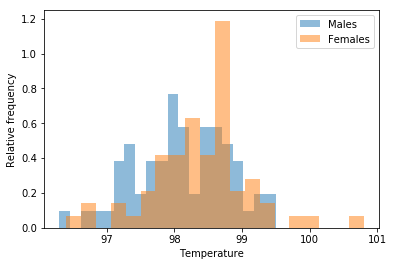

In [27]:
plt.hist(temp_m, bins=20, normed=True, label='Males', alpha=0.5)
plt.hist(temp_f, bins=20, normed=True, label='Females', alpha=0.5)
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Relative frequency')

The higher average female temperatures seem mainly as the result of the samples around 100-101 F.
There may be various sources of variation and bias in the sample, which may include sick people, sampling women at different phases of the monthly cycle, or different racial composition of the samples (black women have been found to have statistically significant higher temperatures than white ones).